# Logit and assignment

In [1]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel
from quetzal.io import excel
import pandas as pd
if manual:
    %matplotlib inline

PyTables is not installed. No support for HDF output.


In [3]:
training_folder = '../../'
plot_path = training_folder + 'outputs/plot/'

In [4]:
distribution = stepmodel.read_zippedpickles(training_folder + r'models/{scen}/distribution'.format(scen=scenario))
pt = stepmodel.read_zippedpickles(training_folder + r'models/{scen}/pruning_pt_pathfinder'.format(scen=scenario))
car = stepmodel.read_zippedpickles(training_folder + r'models/{scen}/aon_pathfinder'.format(scen=scenario))

zone_to_transit: 100%|██████████| 31/31 [00:01<00:00, 28.18it/s]


In [5]:
sm = pt.copy()
sm.car_los = car.car_los
sm.volumes = distribution.volumes
# each segment will be processed independently in the logit
sm.segments = ['car_owner', 'pt_captive'] 

In [6]:
# the scenario specific variables are read from the parameter file
var = excel.read_var(file='../../inputs/parameters.xlsx', scenario=scenario)

In [7]:
var['preparation_logit']

parameter
time        -0.00055
price             -1
transfers      -0.25
mode               1
pt_mode          0.5
pt_path          0.1
Name: base, dtype: object

In [8]:
kwargs = var['preparation_logit'].to_dict()
kwargs

{'time': -0.00055,
 'price': -1,
 'transfers': -0.25,
 'mode': 1,
 'pt_mode': 0.5,
 'pt_path': 0.1}

# LOGIT SCALES

In [9]:
kwargs

{'time': -0.00055,
 'price': -1,
 'transfers': -0.25,
 'mode': 1,
 'pt_mode': 0.5,
 'pt_path': 0.1}

In [10]:
sm.preparation_logit(
    segments=['car_owner', 'pt_captive'],
    **kwargs
)

In [11]:
sm.utility_values.T

value          time  price  ntransfers  mode_utility
segment                                             
root       -0.00055   -1.0       -0.25           1.0
car_owner  -0.00055   -1.0       -0.25           1.0
pt_captive -0.00055   -1.0       -0.25           1.0

In [12]:
sm.logit_scales.T # phi

route_type  car  rail  walk  tram  root  bus  subway   pt
segment                                                  
root        0.0   0.1   0.0   0.1   1.0  0.1     0.1  0.5
car_owner   0.0   0.1   0.0   0.1   1.0  0.1     0.1  0.5
pt_captive  0.0   0.1   0.0   0.1   1.0  0.1     0.1  0.5

In [13]:
sm.mode_utility.T

route_type  car  rail  walk  tram  root  bus  subway
segment                                             
root          0     0     0     0     0    0       0
car_owner     0     0     0     0     0    0       0
pt_captive    0     0     0     0     0    0       0

In [14]:
sm.mode_utility.loc[ 'car', 'pt_captive'] = -100 # PT captive can not use the car
sm.mode_utility.T

route_type  car  rail  walk  tram  root  bus  subway
segment                                             
root          0     0     0     0     0    0       0
car_owner     0     0     0     0     0    0       0
pt_captive -100     0     0     0     0    0       0

In [15]:
sm.mode_nests.T # nested structure can be set for each segment

route_type   car rail  walk tram root bus subway    pt
segment                                               
root        root   pt  root   pt  NaN  pt     pt  root
car_owner   root   pt  root   pt  NaN  pt     pt  root
pt_captive  root   pt  root   pt  NaN  pt     pt  root

# UTILITY EVALUATION
## add relevant columns to path dataframes

In [16]:
sm.pt_los['ntransfers'] = sm.pt_los['alighting_links'].apply(lambda x: max(len(x)-1, 0))
sm.pt_los['price'] = 0  # sm.analysis_pt_fare()
sm.car_los['ntransfers'] = 0
sm.car_los['price'] = 0

## calculate utility

In [17]:
# builds 'time' in pt_los based on the paths
sm.analysis_pt_time() 

# builds 'route_type' in pt_los based on 'route_types'
sm.analysis_pt_route_type(hierarchy=[ 'car','rail', 'subway', 'tram', 'bus', 'walk'])
sm.analysis_car_route_type() # add route_type = 'car' in car_los

# concatenate pt_los and car_los
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index(drop=True)
sm.los['path'] = sm.los['path'].apply(lambda p: tuple(p)) # détail

# add segment specific mode utility column
sm.analysis_mode_utility()

100%|██████████| 2/2 [00:00<00:00, 34.48it/s]


In [18]:
sm.los.head()

origin destination        gtime  \
0  zone_0      zone_0     0.000000   
1  zone_0      zone_1   647.986131   
2  zone_0     zone_10  2978.297539   
3  zone_0    zone_100  7641.700899   
4  zone_0    zone_101  9661.721769   

                                                path reversed  \
0                                          (zone_0,)    False   
1                    (zone_0, stop_area_167, zone_1)    False   
2  (zone_0, stop_area_58, stop_area_472, stop_are...    False   
3  (zone_0, stop_area_167, stop_area_875, stop_ar...    False   
4  (zone_0, stop_area_687, stop_area_157, stop_ar...    False   

  pathfinder_session               broken_modes boardings alightings  \
0       mode_breaker  {subway, bus, rail, tram}        []         []   
1       mode_breaker  {subway, bus, rail, tram}        []         []   
2       mode_breaker  {subway, bus, rail, tram}        []         []   
3       mode_breaker  {subway, bus, rail, tram}        []         []   
4       mode_breaker  {subway, bus, rail, tram}        []         []   

                                           node_path  ... footpath_time  \
0                                                 []  ...      0.000000   
1                                    [stop_area_167]  ...      0.000000   
2  [stop_area_58, stop_area_472, stop_area_1010, ...  ...   2252.852231   
3  [stop_area_167, stop_area_875, stop_area_664, ...  ...   7083.703287   
4  [stop_area_687, stop_area_157, stop_area_713, ...  ...   8773.223710   

  in_vehicle_time waiting_time boarding_time         time route_types  \
0             0.0          0.0           0.0     0.000000          ()   
1             0.0          0.0           0.0   647.986131          ()   
2             0.0          0.0           0.0  2978.297539          ()   
3             0.0          0.0           0.0  7641.700899          ()   
4             0.0          0.0           0.0  9661.721769          ()   

  route_type  mode_utility  (car_owner, utility)  (pt_captive, utility)  
0       walk             0              0.000000               0.000000  
1       walk             0             -0.356392              -0.356392  
2       walk             0             -1.638064              -1.638064  
3       walk             0             -4.202935              -4.202935  
4       walk             0             -5.313947              -5.313947  

[5 rows x 33 columns]

## calulate the utilities and the probabilities

In [19]:
sm.initialize_logit()
sm.step_logit()

100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


In [20]:
sm.los.head(2) # utility and probability columns were added

origin destination       gtime                             path reversed  \
0  zone_0      zone_0    0.000000                        (zone_0,)    False   
1  zone_0      zone_1  647.986131  (zone_0, stop_area_167, zone_1)    False   

  pathfinder_session               broken_modes boardings alightings  \
0       mode_breaker  {subway, bus, rail, tram}        []         []   
1       mode_breaker  {subway, bus, rail, tram}        []         []   

         node_path  ... waiting_time boarding_time        time route_types  \
0               []  ...          0.0           0.0    0.000000          ()   
1  [stop_area_167]  ...          0.0           0.0  647.986131          ()   

  route_type mode_utility (car_owner, utility)  (pt_captive, utility)  \
0       walk            0             0.000000               0.000000   
1       walk            0            -0.356392              -0.356392   

   (car_owner, probability)  (pt_captive, probability)  
0                  0.500000                        1.0  
1                  0.481221                        1.0  

[2 rows x 35 columns]

In [21]:
sm.volumes

origin destination  car_owner  pt_captive
0        zone_0      zone_0   0.004901    0.009516
1        zone_0      zone_1   0.144227    0.317718
2        zone_0      zone_2   0.134494    0.257795
3        zone_0      zone_3   0.190657    0.443399
4        zone_0      zone_4   0.181616    0.418649
...         ...         ...        ...         ...
12095  zone_109    zone_105   0.551036    1.389062
12096  zone_109    zone_106   2.260512    7.249143
12097  zone_109    zone_107   1.637532    4.757378
12098  zone_109    zone_108   1.345095    3.917599
12099  zone_109    zone_109   0.242579    0.529453

[12100 rows x 4 columns]

# ASSIGNMENT

In [22]:
sm.compute_los_volume()

In [23]:
sm.pt_los = sm.los.copy()
sm.pt_los = sm.pt_los.loc[sm.pt_los['route_type'] != 'car']
sm.step_pt_assignment(
    volume_column=None,
    road=True,
    boardings=True,
    alightings=True,
    transfers=True,
)

  0%|          | 0/2 [00:00<?, ?it/s]

pt_captive: 100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


In [24]:
sm.links

a              trip_id  link_sequence  departure_time  \
link_0     stop_area_163  098098001:DIRECT1_0              1         27600.0   
link_1     stop_area_145  098098001:DIRECT1_0              2         27900.0   
link_2     stop_area_768  098098001:DIRECT1_1              1         27540.0   
link_3     stop_area_145  098098001:DIRECT1_1              2         28800.0   
link_4     stop_area_866  098098002:DIRECT2_0              1         28800.0   
...                  ...                  ...            ...             ...   
link_5001  stop_area_465              810:B_1              2         31800.0   
link_5002  stop_area_110              810:B_1              3         31920.0   
link_5003  stop_area_525              810:B_1              4         32040.0   
link_5004  stop_area_315              810:B_1              5         32160.0   
link_5005  stop_area_320              810:B_1              6         32280.0   

                       b  arrival_time    time  headway           pattern_id  \
link_0     stop_area_145       27900.0   300.0     1200  098098001:DIRECT1_0   
link_1     stop_area_768       29100.0  1200.0     1200  098098001:DIRECT1_0   
link_2     stop_area_145       28800.0  1260.0     1200  098098001:DIRECT1_1   
link_3     stop_area_163       29220.0   420.0     1200  098098001:DIRECT1_1   
link_4     stop_area_163       29400.0   600.0     1800  098098002:DIRECT2_0   
...                  ...           ...     ...      ...                  ...   
link_5001  stop_area_110       31860.0    60.0       90              810:B_1   
link_5002  stop_area_525       31980.0    60.0       90              810:B_1   
link_5003  stop_area_315       32100.0    60.0       90              810:B_1   
link_5004  stop_area_320       32220.0    60.0       90              810:B_1   
link_5005  stop_area_485       32400.0   120.0       90              810:B_1   

                    route_id  ...    length duration    cost         origin  \
link_0     098098001:DIRECT1  ...  1460.896    300.0   900.0  stop_area_163   
link_1     098098001:DIRECT1  ...  4925.289   1200.0  1800.0  stop_area_145   
link_2     098098001:DIRECT1  ...  4941.160   1260.0  1860.0  stop_area_768   
link_3     098098001:DIRECT1  ...  1702.389    420.0  1020.0  stop_area_145   
link_4     098098002:DIRECT2  ...  2442.716    600.0  1500.0  stop_area_866   
...                      ...  ...       ...      ...     ...            ...   
link_5001              810:B  ...       NaN     60.0   105.0  stop_area_465   
link_5002              810:B  ...       NaN     60.0   105.0  stop_area_110   
link_5003              810:B  ...       NaN     60.0   105.0  stop_area_525   
link_5004              810:B  ...       NaN     60.0   105.0  stop_area_315   
link_5005              810:B  ...       NaN    120.0   165.0  stop_area_320   

             destination    color         load  transfers    boardings  \
link_0     stop_area_145  #B20066     0.000000        0.0     0.000000   
link_1     stop_area_768  #B20066     0.000000        0.0     0.000000   
link_2     stop_area_145  #B20066     0.000000        0.0     0.000000   
link_3     stop_area_163  #B20066     0.000000        0.0     0.000000   
link_4     stop_area_163  #7BBB58     0.000000        0.0     0.000000   
...                  ...      ...          ...        ...          ...   
link_5001  stop_area_110  #4B92DB  5222.323283        0.0  1692.413617   
link_5002  stop_area_525  #4B92DB  4327.613909        0.0   555.374566   
link_5003  stop_area_315  #4B92DB  3228.485570        0.0   201.922528   
link_5004  stop_area_320  #4B92DB  3208.633431        0.0     8.026268   
link_5005  stop_area_485  #4B92DB  1683.042660        0.0   108.920642   

            alightings  
link_0        0.000000  
link_1        0.000000  
link_2        0.000000  
link_3        0.000000  
link_4        0.000000  
...                ...  
link_5001  1450.083940  
link_5002  1301.050868  
link_5003    27.878407  
link_5004  16

In [25]:
sm.nodes

geometry         load  \
stop_area_0     POINT (263413.15077489655 6251539.643479538)  3466.452619   
stop_area_1     POINT (261960.10557397662 6251248.761464611)   597.573877   
stop_area_2      POINT (264063.8345640195 6249231.802855195)  1528.460247   
stop_area_3      POINT (257100.37899040242 6246169.87027031)  1083.442094   
stop_area_4     POINT (261788.87764388815 6244728.881064177)   263.387585   
...                                                      ...          ...   
stop_area_1020  POINT (262430.18923034816 6246259.833266888)    57.879434   
stop_area_1021  POINT (255700.42507418626 6247071.414343465)    72.637820   
stop_area_1022  POINT (254665.82172675352 6248679.078393495)   106.366374   
stop_area_1023  POINT (263918.80912098126 6252825.852719227)   919.518895   
stop_area_1024  POINT (255945.99587087618 6254282.775934704)    95.715198   

                 transfers    boardings   alightings  
stop_area_0     174.548246  1599.802421  1742.095100  
stop_area_1       0.000000    93.332298   195.896892  
stop_area_2      46.083494   241.810314   907.779138  
stop_area_3       0.000000    99.922007   133.486658  
stop_area_4       0.000000     0.000000     0.642770  
...                    ...          ...          ...  
stop_area_1020    8.079516    10.562846    17.110345  
stop_area_1021    0.000000     0.000000     0.000000  
stop_area_1022    0.000000    30.332707    44.885296  
stop_area_1023  118.348973   517.176325   445.282716  
stop_area_1024   29.684153    38.719007    43.098229  

[1025 rows x 5 columns]

In [26]:
sm.volumes

origin destination  car_owner  pt_captive
0        zone_0      zone_0   0.004901    0.009516
1        zone_0      zone_1   0.144227    0.317718
2        zone_0      zone_2   0.134494    0.257795
3        zone_0      zone_3   0.190657    0.443399
4        zone_0      zone_4   0.181616    0.418649
...         ...         ...        ...         ...
12095  zone_109    zone_105   0.551036    1.389062
12096  zone_109    zone_106   2.260512    7.249143
12097  zone_109    zone_107   1.637532    4.757378
12098  zone_109    zone_108   1.345095    3.917599
12099  zone_109    zone_109   0.242579    0.529453

[12100 rows x 4 columns]

# XLSX EXPORT

In [27]:
sm.links.rename(columns={'load': 'volume'}, inplace=True)
sm.analysis_pt_length()
sm.analysis_car_length()
sm.analysis_pt_time()

In [28]:
sm.summary_link_max(inplace=True)
sm.summary_link_sum(inplace=True)
sm.summary_od(inplace=True)

In [29]:
# (re)concatenate pt_los and car_los
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index(drop=True)

In [30]:
sm.summary_path_average(inplace=True)
sm.summary_aggregated_path_average(inplace=True, pt_route_types=['subway', 'bus', 'tram', 'rail'])
sm.summary_path_sum(inplace=True)

s = sm.stack_link_sum.unstack([-1, -2]).groupby(level=0).sum().stack([0, 1])
s.name = 'sum'
sm.stack_aggregated_link_sum = s 
s = sm.stack_link_max.unstack().groupby(level=0).max().stack()
s.name = 'max'
sm.stack_aggregated_link_max = s

In [31]:
stacks = {name[6:]: attr for name, attr in sm.__dict__.items() if name[:5] == 'stack'}
with pd.ExcelWriter(training_folder + r'models/%s/stacks.xlsx'%scenario) as writer:  
    for name, stack in stacks.items():
        stack.reset_index().to_excel(writer, sheet_name=name, index=False)

In [32]:
sm.od_los

segment                    car_owner                                    \
sum                           volume price        time in_vehicle_time   
origin  destination mode                                                 
zone_0  zone_0      car     0.000000   0.0    0.000000        0.000000   
                    walk    0.002451   0.0    0.000000        0.000000   
        zone_1      car     0.000000   0.0    0.000000        0.000000   
                    walk    0.069405   0.0  311.824675        0.000000   
        zone_10     bus     0.013537   0.0  289.704397      151.125226   
...                              ...   ...         ...             ...   
zone_99 zone_98     subway  0.049874   0.0   92.605120       35.133907   
                    tram    0.317268   0.0  383.437581      175.608900   
                    walk    0.114165   0.0  359.880448        0.000000   
        zone_99     car     0.000000   0.0    0.000000        0.000000   
                    walk    0.290871   0.0    0.000000        0.000000   

segment                                                 pt_captive        \
sum                        in_vehicle_length ntransfers     volume price   
origin  destination mode                                                   
zone_0  zone_0      car             0.000000   0.000000   0.000000   0.0   
                    walk            0.000000   0.000000   0.009516   0.0   
        zone_1      car             0.000000   0.000000   0.000000   0.0   
                    walk            0.000000   0.000000   0.317718   0.0   
        zone_10     bus          1041.601023   0.000000   0.045554   0.0   
...                                      ...        ...        ...   ...   
zone_99 zone_98     subway          0.000000   0.083652   0.218248   0.0   
                    tram            0.000000   0.000000   1.388373   0.0   
                    walk            0.000000   0.000000   0.499588   0.0   
        zone_99     car             0.000000   0.000000   0.000000   0.0   
                    walk            0.000000   0.000000   0.989722   0.0   

segment                                                                   \
sum                               time in_vehicle_time in_vehicle_length   
origin  destination mode                                                   
zone_0  zone_0      car       0.000000        0.000000          0.000000   
                    walk      0.000000        0.000000          0.000000   
        zone_1      car       0.000000        0.000000          0.000000   
                    walk    647.986131        0.000000          0.000000   
        zone_10     bus     475.946920      248.279234       1711.215996   
...                                ...             ...               ...   
zone_99 zone_98     subway  172.530827       65.457309          0.000000   
                    tram    714.375219      327.173580          0.000000   
                    walk    670.486374        0.000000          0.000000   
        zone_99     car       0.000000        0.000000          0.000000   
                    walk      0.000000        0.000000          0.000000   

segment                                    root                    \
sum                        ntransfers    volume price        time   
origin  destination mode                                            
zone_0  zone_0      car      0.000000  0.000000   0.0    0.000000   
                    walk     0.000000  0.011967   0.0    0.000000   
        zone_1      car      0.000000  0.000000   0.0    0.000000   
                    walk     0.000000  0.387123   0.0  587.717747   
        zone_10     bus      0.000000  0.059091   0.0  433.282272   
...                               ...       ...   ...         ...   
zone_99 zone_98     subway   0.155851  0.268122   0.0  157.663754   
                    tram     0.000000  1.705642   0.0  652.817125   
                    walk     0.000000  0.613753   0.0  612.710205   
     

# GEOJSON EXPORT

In [33]:
if manual:
    sm.to_json(training_folder + 'json', omitted_attributes=['pt_los', 'car_los', 'los', 'od_los', 'probabilities', 'utilities'])

to_hdf(overwriting): 100%|██████████| 51/51 [00:18<00:00,  2.69it/s]

could not save attribute: missing_nodes
could not save attribute: missing_road_nodes
could not save attribute: networkcaster
could not save attribute: orphan_nodes


# ZIP EXPORT

In [34]:
sm.to_zippedpickles(training_folder + 'models/{scen}/logit'.format(scen=scenario), omitted_attributes=['los'])

  0%|          | 0/51 [00:00<?, ?it/s]

stack_aggregated_link_max: 100%|██████████| 51/51 [00:04<00:00, 11.21it/s]    


# PLOT

In [35]:
import numpy as np
paths = sm.pt_los
link_routes = sm.links['route_short_name'].to_dict()
def link_path_to_routes(link_path):
    routes = [link_routes[l] for l in link_path]
    used = set()
    rsn = []
    for route in routes:
        if route not in used:
            rsn.append(route)
        used.add(route)
    return rsn

paths['route_path'] = paths['link_path'].apply(link_path_to_routes)
paths['ntransfers'] = paths['transfers'].apply(len)

def title(paths):
    paths['min'] = np.round(paths['time'] / 60).astype(int)
    mins = (paths[['in_vehicle_time', 'access_time', 'footpath_time', 'waiting_time', 'time']] / 60).astype(int).astype(str)
    title = 'P = ' + (np.round(paths[('pt_captive', 'probability')], 2).fillna(0) * 100).astype(int).astype(str) + '%'
    title += ' | '+  paths['ntransfers'].astype(str) + ' transfers '
    title += ' | '+  paths['min'].astype(str) + ' mins | '
    title += paths['route_path'].apply(lambda l: '—>'.join(l) )
    title += '\n'+ 'in vehicle '+ mins['in_vehicle_time']+ "' | " + ' waiting '+ mins['waiting_time']+ "' | "  
    title += 'access ' + mins['access_time']+ "' | "   + ' footpaths '  + mins['footpath_time']+ "'"   
    return title


paths['title'] = title(paths)

In [36]:
plot_sm = sm.copy()

In [37]:
los = plot_sm.pt_los.copy()
los= los.loc[los[('pt_captive', 'probability')] > 0.01]
plot_sm.pt_los = los.sort_values(('pt_captive', 'probability'), ascending=False)

100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


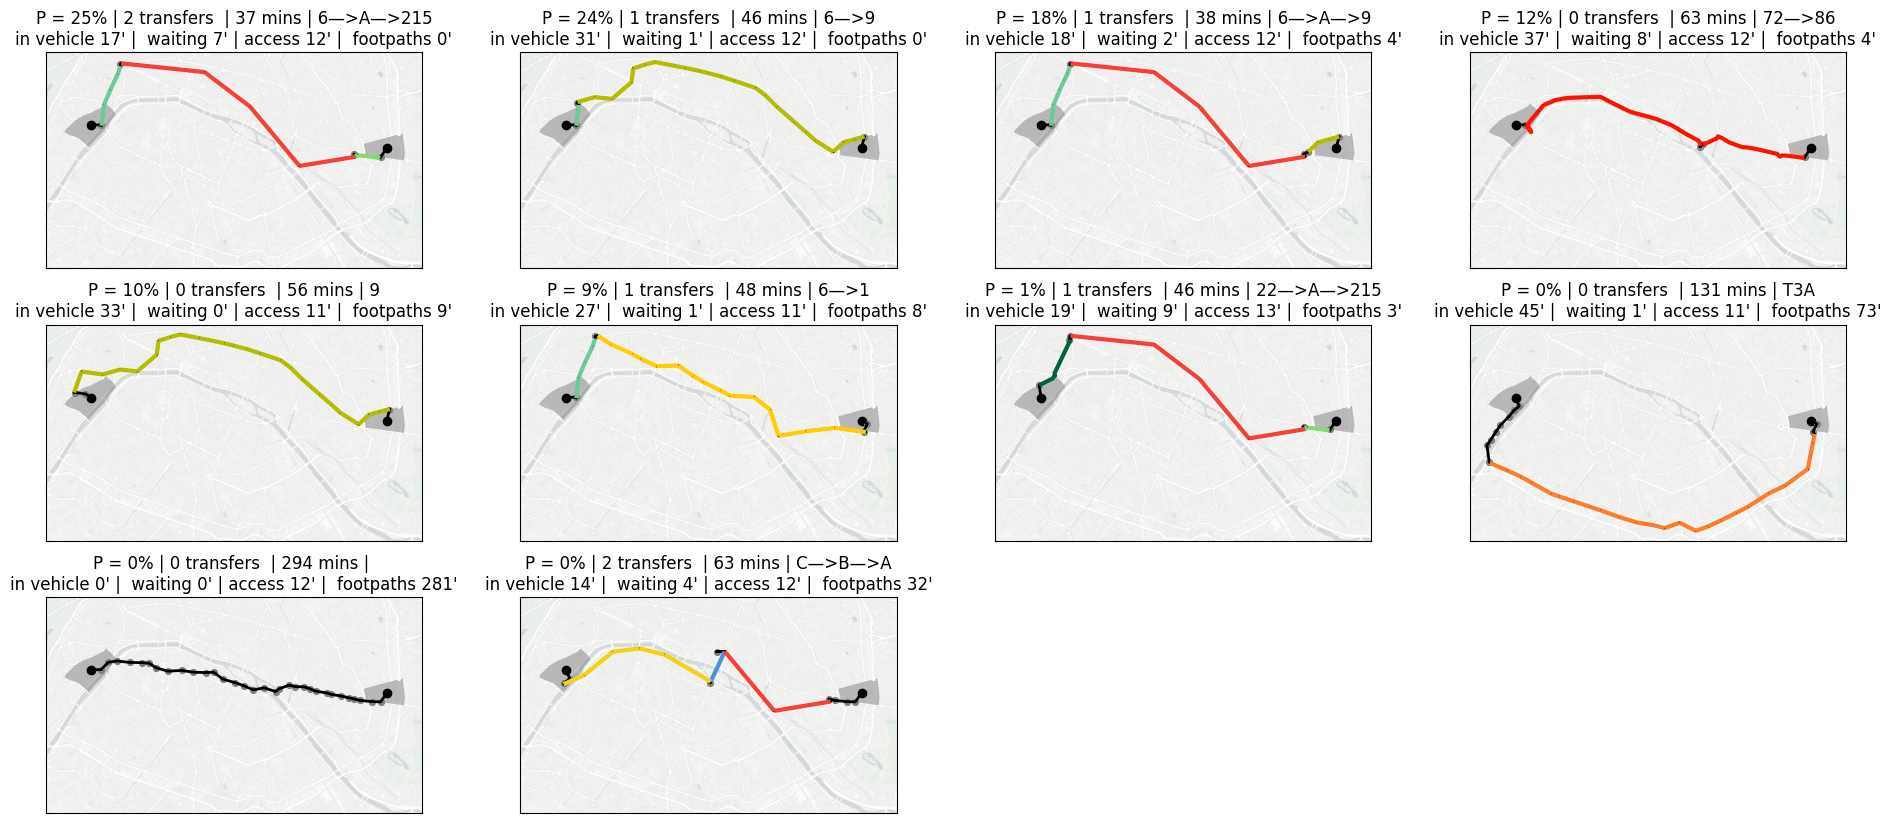

In [38]:
sm.pt_los = sm.pt_los.sort_values(('pt_captive', 'probability'), ascending=False)
if manual:
    origin, destination='zone_75',  'zone_106'
    n =  len(sm.pt_los.set_index(['origin', 'destination']).loc[(origin, destination)])

    rows = 2
    if n > 6:
        rows = 3
    if n > 12:
        rows = 4

    columns = n // rows + bool(n%rows)


    url = 'http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png'
    fig, axes = sm.plot_separated_paths(
        origin, destination, rows=rows, figsize=[20, 20],
        title='title', constrained_layout=True,
        basemap_url=url, zoom=13
    )
    ax = fig.get_axes()[0]
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.set_size_inches(bbox.width*columns, rows*(bbox.height))
    fig.constrained_layout = True
fig.savefig(plot_path + 'logit.png', bbox_inches='tight')

100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


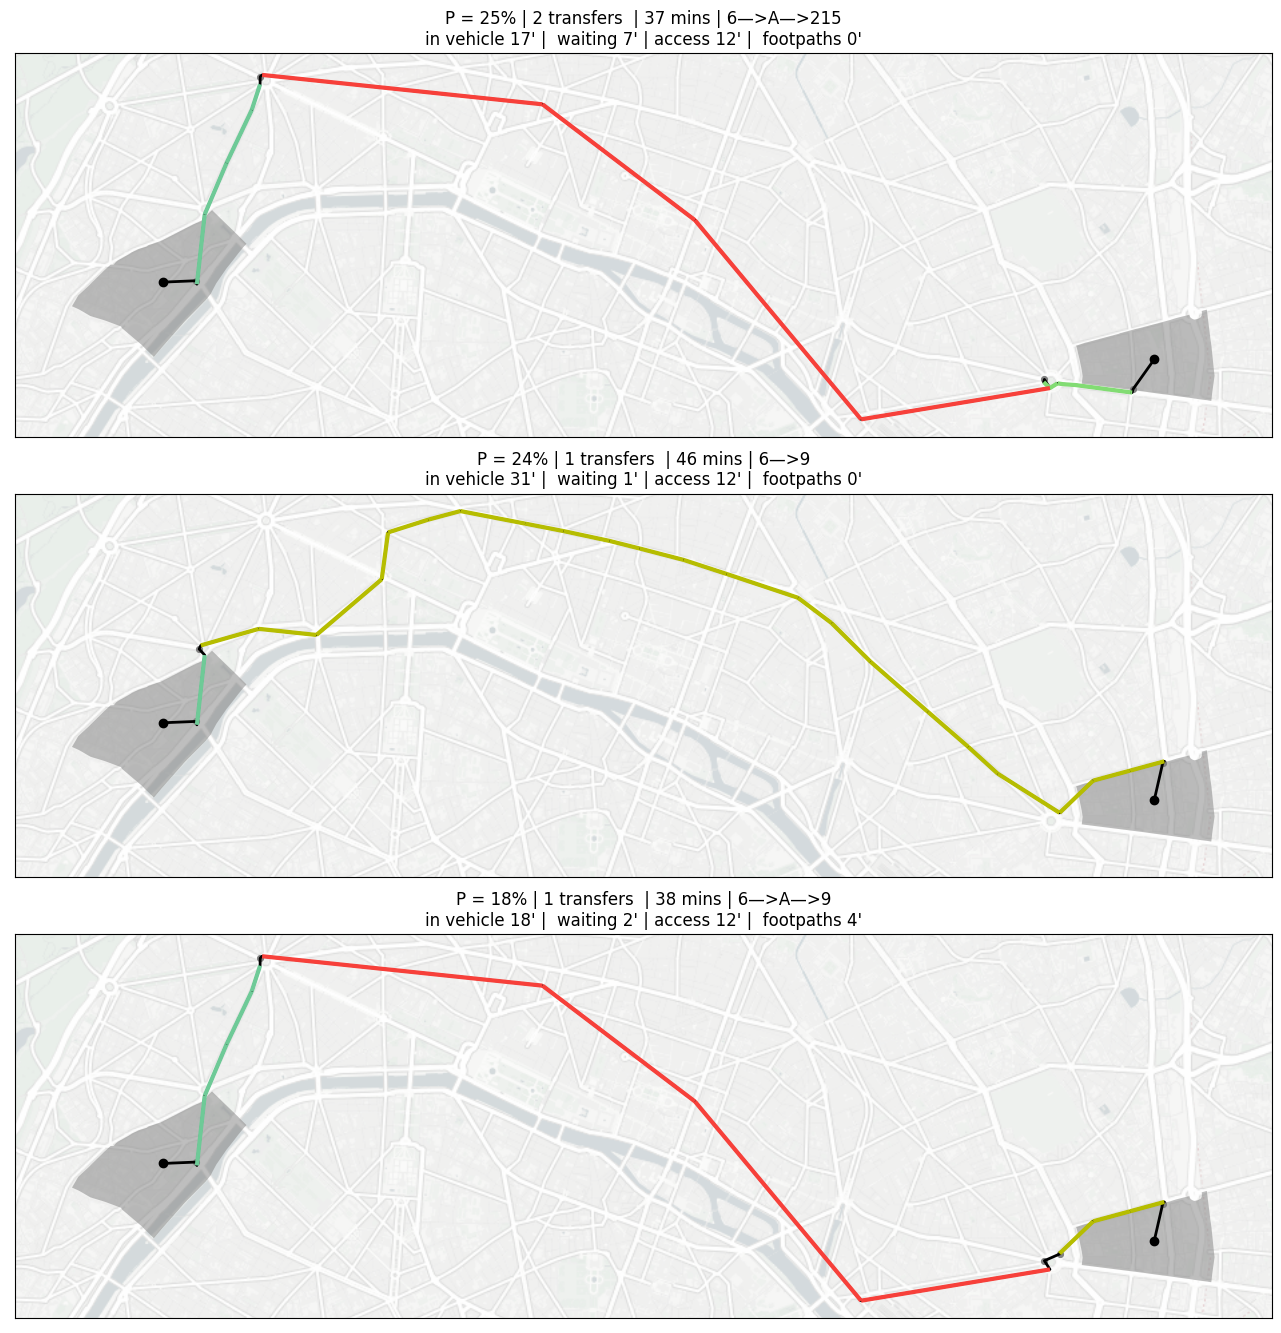

In [39]:
los = plot_sm.pt_los.copy()
los= los.loc[los[('pt_captive', 'probability')] > 0.15]
plot_sm.pt_los = los.sort_values(('pt_captive', 'probability'), ascending=False)
sm.pt_los = sm.pt_los.sort_values(('pt_captive', 'probability'), ascending=False)
if manual:
    origin, destination='zone_75',  'zone_106'
    n =  len(sm.pt_los.set_index(['origin', 'destination']).loc[(origin, destination)])

    rows = 2
    if n > 6:
        rows = 3
    if n > 12:
        rows = 4

    columns = n // rows + bool(n%rows)


    url = 'http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png'
    fig, axes = plot_sm.plot_separated_paths(
        origin, destination, rows=rows, figsize=[15, 15],
        title='title', constrained_layout=True,
        basemap_url=url, zoom=13
    )
    ax = fig.get_axes()[0]
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.set_size_inches(bbox.width*columns, rows*(bbox.height))
    fig.constrained_layout = True


In [40]:
fig.savefig(plot_path + 'logit.png', bbox_inches='tight')

100%|██████████| 4/4 [00:04<00:00,  1.25s/it]


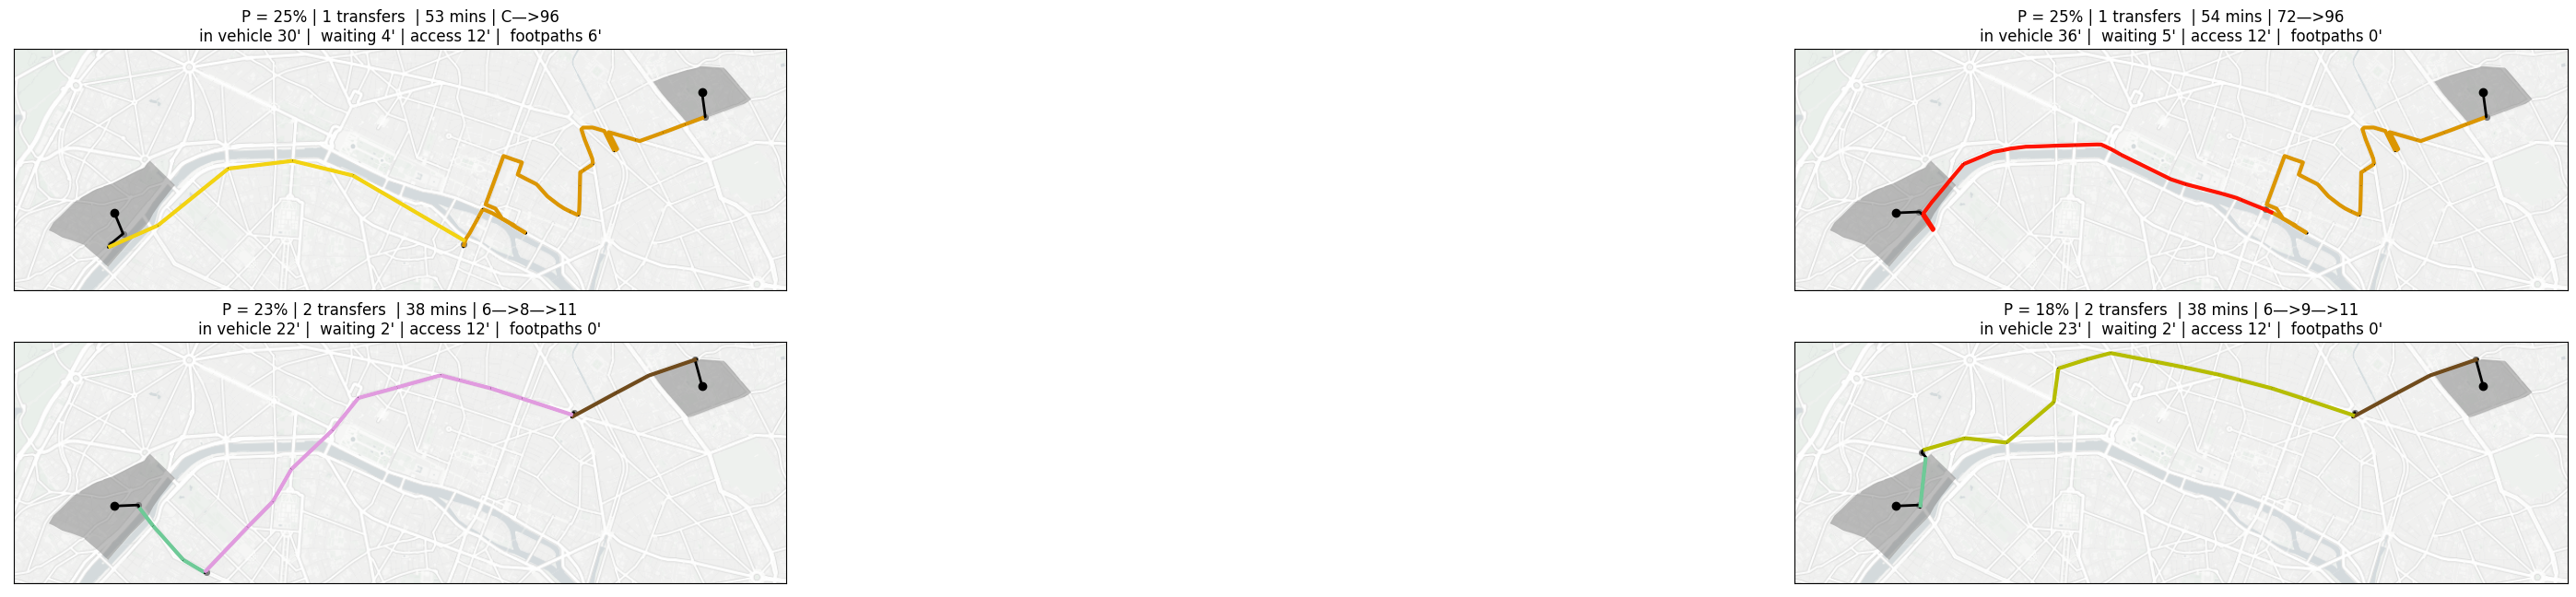

In [41]:
if manual:
    origin, destination='zone_75',  'zone_105'
    n =  len(sm.pt_los.set_index(['origin', 'destination']).loc[(origin, destination)])

    rows = 2
    if n > 6:
        rows = 3
    if n > 12:
        rows = 4

    columns = n // rows + bool(n%rows)


    url = 'http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png'
    fig, axes = plot_sm.plot_separated_paths(
        origin, destination, rows=rows, figsize=[20, 20],
        title='title', constrained_layout=True,
        basemap_url=url, zoom=13
    )
    ax = fig.get_axes()[0]
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.set_size_inches(bbox.width*columns, rows*(bbox.height))
    fig.constrained_layout = True

100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


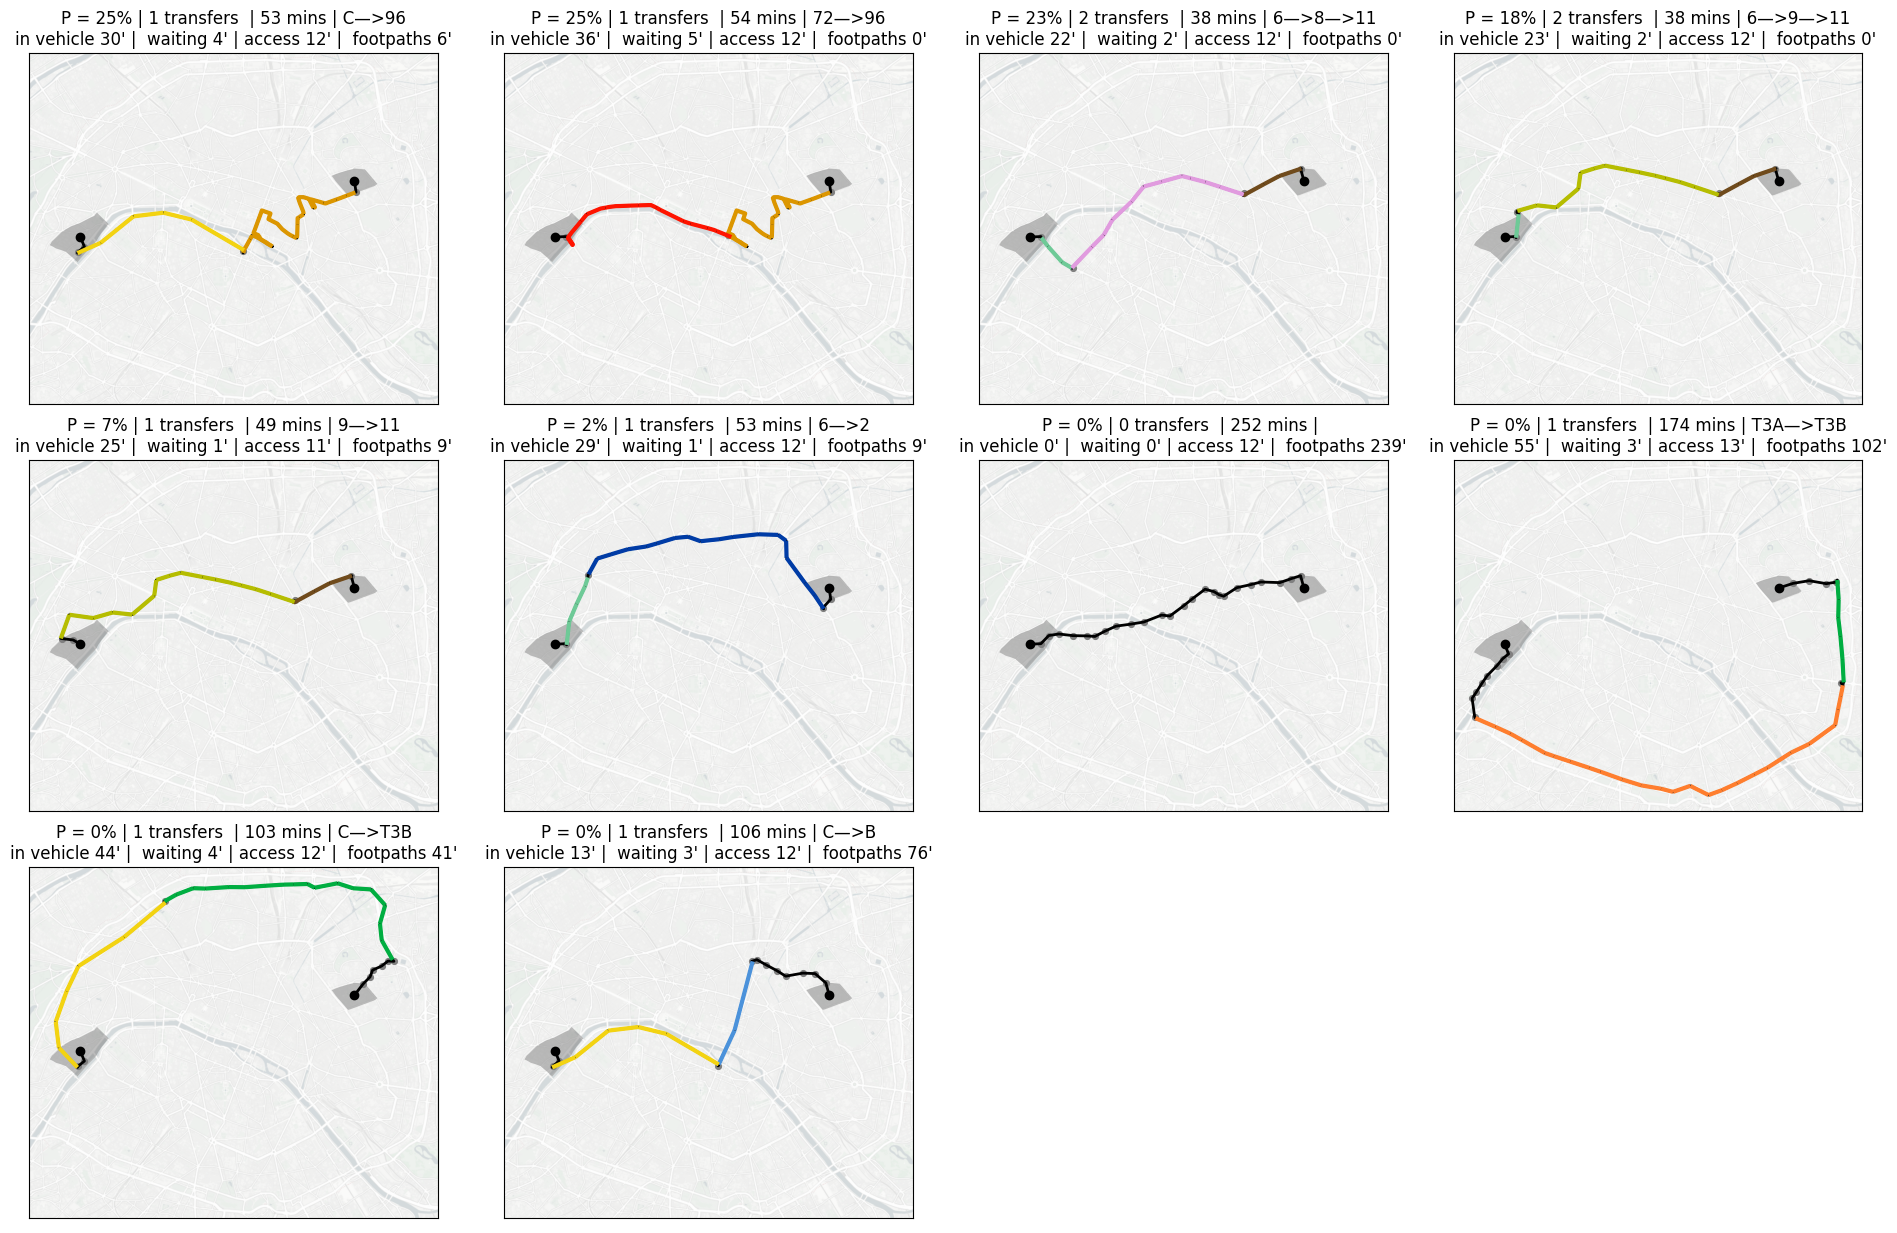

In [42]:
if manual:
    origin, destination='zone_75',  'zone_105'
    n =  len(sm.pt_los.set_index(['origin', 'destination']).loc[(origin, destination)])

    rows = 2
    if n > 6:
        rows = 3
    if n > 12:
        rows = 4

    columns = n // rows + bool(n%rows)


    url = 'http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png'
    fig, axes = sm.plot_separated_paths(
        origin, destination, rows=rows, figsize=[20, 20],
        title='title', constrained_layout=True,
        basemap_url=url, zoom=13
    )
    ax = fig.get_axes()[0]
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.set_size_inches(bbox.width*columns, rows*(bbox.height))
    fig.constrained_layout = True

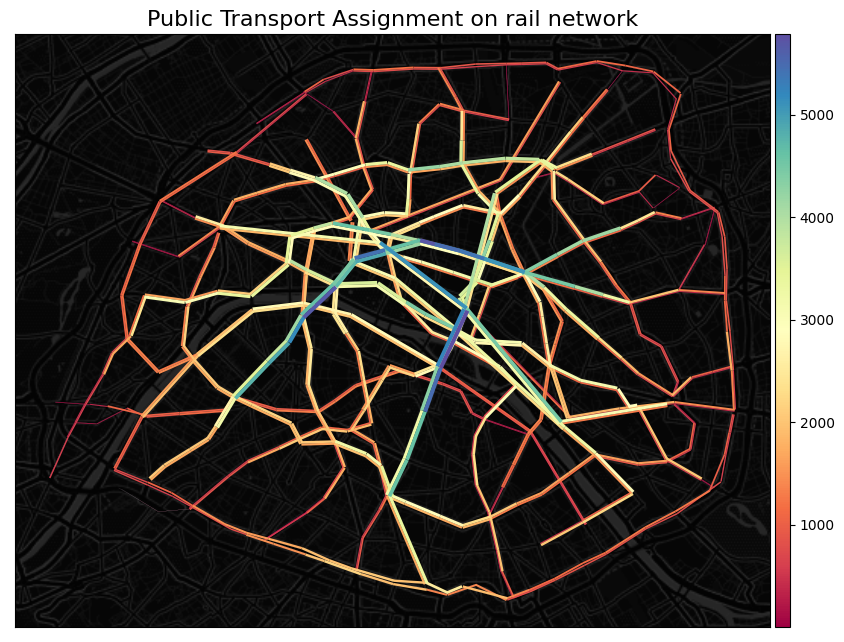

In [43]:
if manual:
    from syspy.syspy_utils import data_visualization as dv
    bandwidth = dv.bandwidth
    power=0.5
    url = 'http://a.basemaps.cartocdn.com/dark_nolabels/tileZ/tileX/tileY.png'

    rail_links = sm.links.loc[sm.links.route_type.isin(['subway', 'rail', 'tram'])]
    df = rail_links
    df['pt'] = df['volume'] 
    df = df.loc[df['pt'] > 0]

    plot = bandwidth(
        df, value_column='pt', power=power, figsize=[10, 10]
    )
    dv.add_basemap(plot, url=url, zoom=12)
    plot.set_title('Public Transport Assignment on rail network', fontsize=16)